In [ ]:
import os
import numpy as np

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-dataset' dataset.
Path to dataset files: /kaggle/input/mnist-dataset


In [ ]:
print(os.listdir(path))

['t10k-labels-idx1-ubyte', 'train-images.idx3-ubyte', 't10k-images-idx3-ubyte', 't10k-labels.idx1-ubyte', 't10k-images.idx3-ubyte', 'train-labels.idx1-ubyte', 'train-labels-idx1-ubyte', 'train-images-idx3-ubyte']


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

full_train_data = datasets.MNIST(
    root="/kaggle/working",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="/kaggle/working",
    train=False,
    download=True,
    transform=transform
)

train_size = int(0.9 * len(full_train_data))
val_size = len(full_train_data) - train_size


train_data, val_data = random_split(
    full_train_data,
    [train_size, val_size]
)

train_loader = DataLoader(train_data, batch_size=60, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=60, shuffle=False)
test_loader = DataLoader(test_data, batch_size=60, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.30MB/s]


In [ ]:
image, label = full_train_data[0]
print(image.shape)

torch.Size([1, 28, 28])


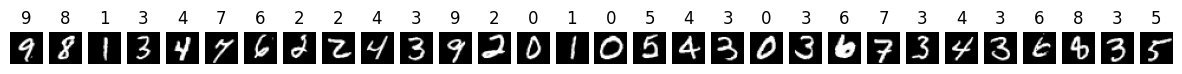

In [ ]:
import matplotlib.pyplot as plt

def show_images_with_labels(images, labels, n=10):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = images[i] * 0.5 + 0.5
        plt.subplot(1, n, i + 1)
        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(str(labels[i].item()))
        plt.axis("off")
    plt.show()


images, labels = next(iter(train_loader))
show_images_with_labels(images, labels, n=30)

In [ ]:
class Linear:
    def __init__(self, in_features, out_features):
        self.W = torch.randn(in_features, out_features) * 0.01
        self.b = torch.zeros(out_features)

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, grad):
        self.dW = self.x.T @ grad
        self.db = grad.sum(dim=0)
        return grad @ self.W.T

In [ ]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad):
        return grad * self.mask

In [ ]:
class Softmax:
    def forward(self, x):
        exp = torch.exp(x - x.max(dim=1, keepdim=True).values)
        self.out = exp / exp.sum(dim=1, keepdim=True)
        return self.out

    def backward(self, grad):
        return grad

In [ ]:
class CrossEntropyLoss:
    def forward(self, probs, targets):
        self.probs = probs
        self.targets = targets
        return -torch.log(probs[range(len(targets)), targets]).mean()

    def backward(self):
        grad = self.probs.clone()
        grad[range(len(self.targets)), self.targets] -= 1
        return grad / len(self.targets)

In [ ]:
def accuracy_from_probs(probs, labels):
    preds = torch.argmax(probs, dim=1)
    return (preds == labels).float().mean().item()

In [ ]:
class Flatten:
    def forward(self, x):
        self.shape = x.shape
        return x.view(x.shape[0], -1)

    def backward(self, grad):
        return grad.view(self.shape)

In [ ]:
class Dropout:
    def __init__(self, p=0.5):
        self.p = p

    def forward(self, x, train=True):
        if train:
            self.mask = (torch.rand_like(x) > self.p)
            return x * self.mask
        return x

    def backward(self, grad):
        return grad * self.mask

In [ ]:
class Adam:
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999):
        self.params = params
        self.lr = lr
        self.m = [torch.zeros_like(p) for p in params]
        self.v = [torch.zeros_like(p) for p in params]
        self.t = 0

    def step(self, grads):
        self.t += 1
        for i, (p, g) in enumerate(zip(self.params, grads)):
            self.m[i] = 0.9 * self.m[i] + 0.1 * g
            self.v[i] = 0.999 * self.v[i] + 0.001 * (g ** 2)
            p -= self.lr * self.m[i] / (torch.sqrt(self.v[i]) + 1e-8)

In [ ]:
import torch

flatten = Flatten()
fc1 = Linear(784, 256)
relu1 = ReLU()
dropout = Dropout(p=0.2)
fc2 = Linear(256, 128)
relu2 = ReLU()
fc3 = Linear(128, 10)
softmax = Softmax()


loss_fn = CrossEntropyLoss()


params = [fc1.W, fc1.b, fc2.W, fc2.b, fc3.W, fc3.b]
optimizer = Adam(params, lr=0.001)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 15

for epoch in range(epochs):
    #train
    total_train_loss = 0
    total_train_acc = 0
    n_batches = 0
    for images, labels in train_loader:

        x = flatten.forward(images)
        x = fc1.forward(x)
        x = relu1.forward(x)
        x = dropout.forward(x, train=True)
        x = fc2.forward(x)
        x = relu2.forward(x)
        x = fc3.forward(x)
        probs = softmax.forward(x)


        loss = loss_fn.forward(probs, labels)
        total_train_loss += loss.item()

        total_train_acc += accuracy_from_probs(probs, labels)
        n_batches += 1


        grad = loss_fn.backward()
        grad = softmax.backward(grad)
        grad = fc3.backward(grad)
        grad = relu2.backward(grad)
        grad = fc2.backward(grad)
        grad = dropout.backward(grad)
        grad = relu1.backward(grad)
        grad = fc1.backward(grad)


        grads = [fc1.dW, fc1.db, fc2.dW, fc2.db, fc3.dW, fc3.db]
        optimizer.step(grads)

    train_losses.append(total_train_loss / n_batches)
    train_accuracies.append(total_train_acc / n_batches)

    #validation
    total_val_loss = 0
    total_val_acc = 0
    n_val_batches = 0
    for images, labels in val_loader:
        x = flatten.forward(images)
        x = fc1.forward(x)
        x = relu1.forward(x)
        x = fc2.forward(x)
        x = relu2.forward(x)
        x = fc3.forward(x)
        probs = softmax.forward(x)

        loss = loss_fn.forward(probs, labels)
        total_val_loss += loss.item()
        total_val_acc += accuracy_from_probs(probs, labels)
        n_val_batches += 1

    val_losses.append(total_val_loss / n_val_batches)
    val_accuracies.append(total_val_acc / n_val_batches)

    print(
        f"Epoch {epoch+1}: "
        f"train_loss={train_losses[-1]:.4f}, "
        f"train_acc={train_accuracies[-1]*100:.2f}%, "
        f"val_loss={val_losses[-1]:.4f}, "
        f"val_acc={val_accuracies[-1]*100:.2f}%"
    )

Epoch 1: train_loss=0.3806, train_acc=87.86%, val_loss=0.1932, val_acc=93.93%
Epoch 2: train_loss=0.2086, train_acc=93.51%, val_loss=0.1641, val_acc=95.10%
Epoch 3: train_loss=0.1728, train_acc=94.58%, val_loss=0.1386, val_acc=95.93%
Epoch 4: train_loss=0.1516, train_acc=95.35%, val_loss=0.1459, val_acc=95.97%
Epoch 5: train_loss=0.1399, train_acc=95.59%, val_loss=0.1197, val_acc=96.52%
Epoch 6: train_loss=0.1310, train_acc=95.95%, val_loss=0.1172, val_acc=96.55%
Epoch 7: train_loss=0.1229, train_acc=96.15%, val_loss=0.1123, val_acc=96.92%
Epoch 8: train_loss=0.1170, train_acc=96.27%, val_loss=0.1114, val_acc=96.88%
Epoch 9: train_loss=0.1115, train_acc=96.50%, val_loss=0.1060, val_acc=96.73%
Epoch 10: train_loss=0.1057, train_acc=96.58%, val_loss=0.1071, val_acc=97.25%
Epoch 11: train_loss=0.1036, train_acc=96.59%, val_loss=0.1175, val_acc=96.73%
Epoch 12: train_loss=0.0980, train_acc=96.81%, val_loss=0.1023, val_acc=97.27%
Epoch 13: train_loss=0.0943, train_acc=96.89%, val_loss=0.110

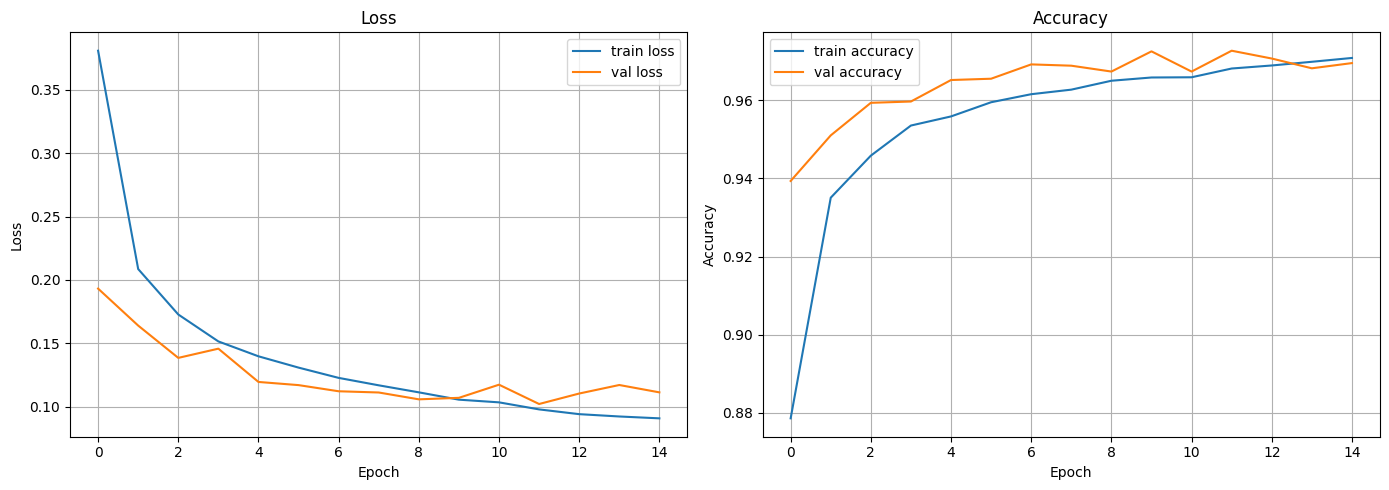

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(train_losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)
axes[0].set_title("Loss")

axes[1].plot(train_accuracies, label="train accuracy")
axes[1].plot(val_accuracies, label="val accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].legend()
axes[1].grid(True)
axes[1].set_title("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
def accuracy(loader):
    correct = 0
    total = 0
    for images, labels in loader:
        x = flatten.forward(images)
        x = fc1.forward(x)
        x = relu1.forward(x)
        x = fc2.forward(x)
        x = relu2.forward(x)
        x = fc3.forward(x)
        probs = softmax.forward(x)
        preds = torch.argmax(probs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total

print("Test accuracy:", accuracy(test_loader))

Test accuracy: 0.0917


In [ ]:
def model_forward(images):
    x = flatten.forward(images)
    x = fc1.forward(x)
    x = relu1.forward(x)
    x = fc2.forward(x)
    x = relu2.forward(x)
    x = fc3.forward(x)
    return softmax.forward(x)

In [ ]:
import torch

def save_model(filename="mymodel.pth"):
    state = {
        "fc1.W": fc1.W,
        "fc1.b": fc1.b,
        "fc2.W": fc2.W,
        "fc2.b": fc2.b,
        "fc3.W": fc3.W,
        "fc3.b": fc3.b,
    }
    torch.save(state, filename)

In [ ]:
def load_model(filename="mymodel.pth"):
    state = torch.load(filename)
    fc1.W = state["fc1.W"]
    fc1.b = state["fc1.b"]
    fc2.W = state["fc2.W"]
    fc2.b = state["fc2.b"]
    fc3.W = state["fc3.W"]
    fc3.b = state["fc3.b"]

In [ ]:
save_model("mymodel_with_1hidden_15ep_reg.pth")

NameError: name 'save_model' is not defined

In [ ]:
from PIL import Image
import PIL.ImageOps

load_model("/content/mymodel_with_1hidden_15ep_reg.pth")

img = Image.open("/content/Снимок экрана 2025-12-22 в 12.10.33.png").convert("L")
img = img.resize((28, 28))
img = PIL.ImageOps.invert(img)
x = transform(img).unsqueeze(0)
x_flat = flatten.forward(x)
x1 = fc1.forward(x_flat)
x1 = relu1.forward(x1)
x2 = fc2.forward(x1)
x2 = relu2.forward(x2)
x3 = fc3.forward(x2)
probs = softmax.forward(x3)
pred = torch.argmax(probs, dim=1).item()
print("Predicted digit:", pred)

Predicted digit: 3


In [ ]:
def plot_roc(model_forward, loader, num_classes=10):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc
    from sklearn.preprocessing import label_binarize

    y_true = []
    y_score = []

    for images, labels in loader:
        probs = model_forward(images)
        y_true.append(labels.numpy())
        y_score.append(probs.detach().numpy())

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)

    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    plt.figure(figsize=(7, 6))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{i} (AUC={roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.grid(True)
    plt.show()

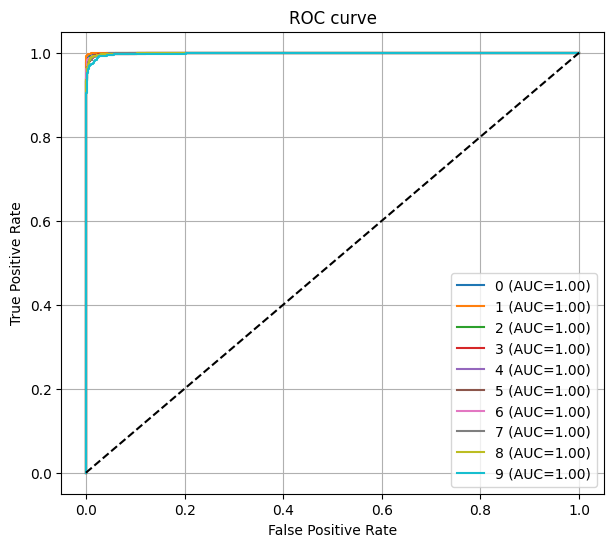

In [ ]:
plot_roc(model_forward, test_loader)